# **Community Detection**
----

### 1. Environment Setup
Click on the button below to open the notebook in Google Colab and run the following commands to install the required libraries.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hardness1020/Community_Detection/blob/main/main.ipynb)

In [ ]:
!git clone https://github.com/hardness1020/Community_Detection.git

In [ ]:
# For colab
%cd Community_Detection
%pip install -r requirements.txt
!git clone https://github.com/6lyc/CDNMF.git
!git clone https://github.com/benedekrozemberczki/DANMF.git

# For local
# %pip install -r requirements.txt
# !git clone https://github.com/6lyc/CDNMF.git
# !git clone https://github.com/benedekrozemberczki/DANMF.git

In [ ]:
# Import packages
import os
import random
import numpy as np
import pandas as pd
import linecache
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, \
    adjusted_rand_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment
from CDNMF.Utils.evaluate import clusterscores
from CDNMF.Dataset.dataset import Dataset
from CDNMF.Model.my_model import Model
from CDNMF.PreTrainer.pretrainer import PreTrainer
from CDNMF.Utils import gpu_info

from spectral_clustering import normalize_eigenvectors, laplacian, \
    generate_labels_dict


# Check GPU
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device)

### 2. Methods
- Our project implements the following community detection algorithms:
  - Spectral Clustering
  - Contrastive Deep Nonnegative Matrix Factorization (CDNMF)
- The output of the prediction of each method were stored in 'prediction/{method}_example.csv'.
  - It is not necessary to run the code to get the output file, as the output files are already stored in the repository.
  - The format of the output file is as follows:
    - Each row represents the category of the corresponding node.

#### 2.1. Spectral Clustering Method
Spectral clustering groups data by leveraging eigenvalues of a similarity graph. It is effective for complex, non-linear cluster structures.

Steps:
- **Similarity Matrix**: Compute pairwise similarities and create a graph adjacency matrix.
- **Laplacian Matrix**: Calculate the graph Laplacian (unnormalized or normalized).
- **Eigen Decomposition**: Extract eigenvectors corresponding to the smallest k eigenvalues.
- **Feature Transformation**: Use eigenvectors as features, normalizing rows if needed.
- **Clustering**: Apply k-means or similar on the transformed features.
Assign Labels: Map cluster results to the original data.

Reference:
- [Community Detection](https://github.com/VedangW/community-detection/blob/main/cdet/spectral_clustering.py)

In [94]:
# Define the spectral clustering function

def spectral_clustering(G, k, laplacian_type="symmetric", **kwargs):
    """
    Implement spectral clustering
    """
    # Calculate Laplacian
    L = laplacian(G, laplacian_type=laplacian_type)

    # Get eigenvectors from the Laplacian
    eig_values, eig_vectors = sp.linalg.eigs(L, k, which='SM')
    
    
    # # Plot the eigenvalues
    # print("Eigenvalues of the Laplacian:")
    # print(eig_values)
    # plt.figure()
    # plt.plot(range(1, len(eig_values) + 1), eig_values, marker='o')
    # plt.title("Eigenvalues of the Laplacian")
    # plt.xlabel("Index")
    # plt.ylabel("Eigenvalue")
    
    # Use eigenvectors as features
    U = eig_vectors.real
    
    if laplacian_type == "symmetric":
        U = np.apply_along_axis(normalize_eigenvectors, 0, U)

    # Cluster using KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(U)
    
    # # Calculate the Sum of Squared Errors (SSE)
    # centroids = kmeans.cluster_centers_
    # pred_clusters = kmeans.predict(U)
    # curr_sse = 0
    # for i in range(len(U)):
    #     curr_center = centroids[pred_clusters[i]]
    #     for j in range(k):
    #         curr_sse += (U[i, j] - curr_center[j]) ** 2
    
    # curr_sse = (curr_sse/k)**(0.5) # normalize the 
    
    
    # Get labels, {cluster:[list of nodes]}
    labels_dict = generate_labels_dict(G, kmeans)


    return labels_dict

In [95]:
# Run the spectral clustering algorithm

cora_G = nx.read_edgelist('dataset/cora/edges.txt', nodetype=int)

labels_dict = spectral_clustering(cora_G, 7, laplacian_type="symmetric")
labels_dict

ArpackNoConvergence: ARPACK error -1: No convergence (27081 iterations, 0/7 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]

Number of nodes: 2708
Number of edges: 5278
[-5.341924793994153e-15, -4.771341972116293e-15, -3.574767538253582e-15, -3.109756588197303e-15, -3.065092658866538e-15, -2.6771231661251746e-15, -2.286535026723385e-15, -2.2330168632454806e-15, -1.7836905558684904e-15, -1.6676406707488857e-15, -1.62131681824281e-15, -1.3663830816838382e-15, -1.3385562815261089e-15, -1.3356771407687368e-15, -1.1516897893186938e-15, -1.1322270498079114e-15, -1.1216438174987632e-15, -1.0421678973937388e-15, -9.877613523267871e-16, -9.25214051381347e-16, -9.157025625619222e-16, -9.154358017024602e-16, -8.935143514396209e-16, -8.912865046703074e-16, -7.715662520789768e-16, -7.313749933916402e-16, -4.946768988699305e-16, -4.753045250151192e-16, -4.51665210887717e-16, -3.2341709986386136e-16, -2.664381881125805e-16, -2.44065655816097e-16, -2.220446049250313e-16, -2.1840103064409625e-16, -1.1102420554132364e-16, -4.2283884755914434e-17, -3.788317804953861e-17, -1.1263713785481769e-63, 4.932391944019277e-18, 7.576001

Text(0.5, 1.0, 'Eigenvalues of the Laplacian')

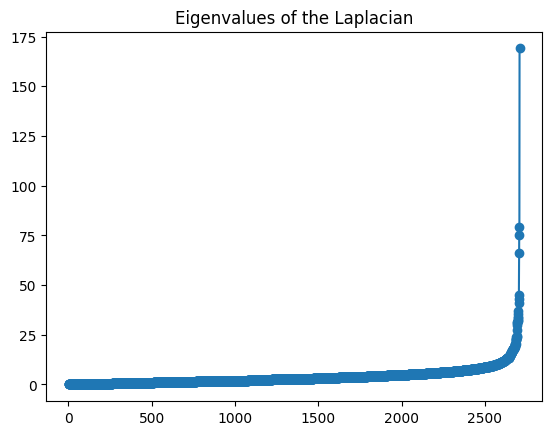

In [55]:
# Run spectral clustering

# Load the graph
cora_G = nx.read_edgelist('dataset/cora/edges.txt', nodetype=int)
print('Number of nodes:', cora_G.number_of_nodes())
print('Number of edges:', cora_G.number_of_edges())

# Calculate the spectral clustering
egn_values = nx.laplacian_spectrum(cora_G)
print(sorted(egn_values))
print("Eigenvalues of the Laplacian:")
plt.figure()
plt.plot(range(1, len(egn_values) + 1), egn_values, marker='o')
plt.title("Eigenvalues of the Laplacian")



#### 2.2. CDNMF Method
- Recommended to use GPU for faster computation.
- Reference: 
  - Paper: [Contrastive deep nonnegative matrix factorization for community detection](https://arxiv.org/abs/2202.12345)
  - Code: [Github](https://github.com/6lyc/CDNMF?tab=readme-ov-file)

In [ ]:
# Set config

random.seed(42)

dataset_config = {'feature_file': './dataset/cora/features.txt',
                  'graph_file': './dataset/cora/edges.txt',
                  'walks_file': './dataset/cora/walks.txt',
                  'label_file': './dataset/cora/group.txt',
                  'device': device}
graph = Dataset(dataset_config)

pretrain_config = {
    'net_shape': [1000, 500, 7],
    'att_shape': [500, 200, 7],
    'net_input_dim': graph.num_nodes,
    'att_input_dim': graph.num_feas,
    'seed': 42,
    'pre_iterations': 100,
    'pretrain_params_path': './CDNMF/Log/cora/pretrain_params.pkl'}

model_config = {
    'device': device,
    'net_shape': [1000, 500, 7],
    'att_shape': [500, 200, 7],
    'net_input_dim': graph.num_nodes,
    'att_input_dim': graph.num_feas,
    'is_init': True,
    'pretrain_params_path': './CDNMF/Log/cora/pretrain_params.pkl',
    'tau': 1.3,
    'conc': 5,
    'negc': 400,
    'rec': 1,
    'r': 3,
    'learning_rate': 0.01,
    'weight_decay': 0.00001,
    'epoch': 550,
    'run': 20,
    'model_path': './CDNMF/Log/cora/cora_model.pkl'
}

In [ ]:
# Run CDNMF model

# Load pretrain params
model = Model(model_config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=model_config['learning_rate'])
    
# Train model
for epoch in tqdm(range(model_config['epoch'])):
    optimizer.zero_grad()
    V = model()

    loss, loss1, loss2, loss3, loss4, loss5 = model.loss(graph)
    loss.backward()
    optimizer.step()
        
# Write y_pred to file
pred_dir = f'./prediction/'
y_pred = np.argmax(V.detach().cpu().numpy(), axis=0)
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)
with open(f'{pred_dir}CDNMF.txt', 'w') as f:
    for i in y_pred:
        f.write(str(i) + '\n')

#### 2.3. DANMF Method
- Time estimation: 47 minutes
- Only CPU is supported.
- Reference: 
  - Paper: [Deep Autoencoder-like Nonnegative Matrix Factorization for Community Detection](https://dl.acm.org/doi/10.1145/3269206.3271697)
  - Code: [Github](https://github.com/benedekrozemberczki/DANMF?tab=readme-ov-file)

In [ ]:
# Run DANMF model 4:07

!python DANMF/src/main.py \
    --layers  2708 256 64 7 \
    --lamb 1 \
    --edge-path ./dataset/cora/edges.csv \
    --output-path ./prediction/DANMF_output.csv \
    --membership-path ./prediction/DANMF_membership.json

In [ ]:
# Process the output of DANMF

import json

with open('./prediction/DANMF_membership.json', 'r') as f:
    membership = json.load(f)
    
    # Convert to the format of label_list
    label_list = []
    for k, v in membership.items():
        label_list.append(v)
        
    # Store the label_list
    with open('./prediction/DANMF.txt', 'w') as f:
        for i in label_list:
            f.write(str(i) + '\n')

### 3. Evaluation
Our project evaluates the performance using the following methods:
- Evaluation Metrics
  - Accuracy
  - NMI (Normalized Mutual Information)
  - ARI (Adjusted Rand Index)
  - AMI (Adjusted Mutual Information)
- Visualization

In [86]:
# Load prediction and ground truth files

# Set the path to the prediction file. 
# By default, the example prediction file is used. 
# Use the other path if running the CDNMF model.


CDNMF_path = 'prediction/CDNMF_example.txt'
DANMF_path = 'prediction/DANMF_example.txt'
# CDNMF_path = 'prediction/CDNMF.txt'
# DANMF_path = 'prediction/DANMF.txt'


y_pred_CDNMF = pd.read_csv(CDNMF_path, header=None).values[:, 0]
y_pred_DANMF = pd.read_csv(DANMF_path, header=None).values[:, 0]
y_true = pd.read_csv('dataset/cora/group.txt', header=None, delimiter=' ').values[:, 1]

#### 3.1. Evaluation Metrics
- **Accuracy**: A ratio of the number of correctly classified samples to the total number of samples.
- **Normalized Mutual Information (NMI)**: A measure of the similarity between two clusterings of a set of data. It is used to assess the quality of clusters created by an algorithm against some ground truth. 
- **Adjusted Rand Index (ARI)**: A measure of the similarity between two data clusterings. It considers all pairs of samples and counts pairs that are assigned in the same or different clusters in the predicted and true clusterings.
- **Adjusted Mutual Information (AMI)**: A measure of the agreement between two clusterings of the same data. It measures the amount of information obtained about one clustering by knowing another.


In [87]:
def cluster_acc(y_pred, y_true):
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max().astype(int), y_true.max().astype(int)) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    # ind = sklearn.utils.linear_assignment_.linear_assignment(w.max() - w)
    # row_ind, col_ind = linear_assignment(w.max() - w)
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size

def clusterscores(pred: np.array, target: np.array):
    ACC = cluster_acc(pred, target)
    NMI = normalized_mutual_info_score(target, pred)
    ARI = adjusted_rand_score(target, pred)
    AMI = adjusted_mutual_info_score(target, pred)
    return {'ACC': ACC, 'NMI': NMI, 'ARI': ARI, 'AMI': AMI}

In [88]:
scores_CDNMF = clusterscores(y_pred_CDNMF, y_true)
scores_DANMF = clusterscores(y_pred_DANMF, y_true)


# Plot the table of results
df = pd.DataFrame([scores_CDNMF, scores_DANMF], index=['CDNMF', 'DANMF'])
df

,ACC,NMI,ARI,AMI
CDNMF,0.614476,0.398002,0.384953,0.395734
DANMF,0.177622,0.003556,0.000925,-0.000106


#### 3.2. Visualization

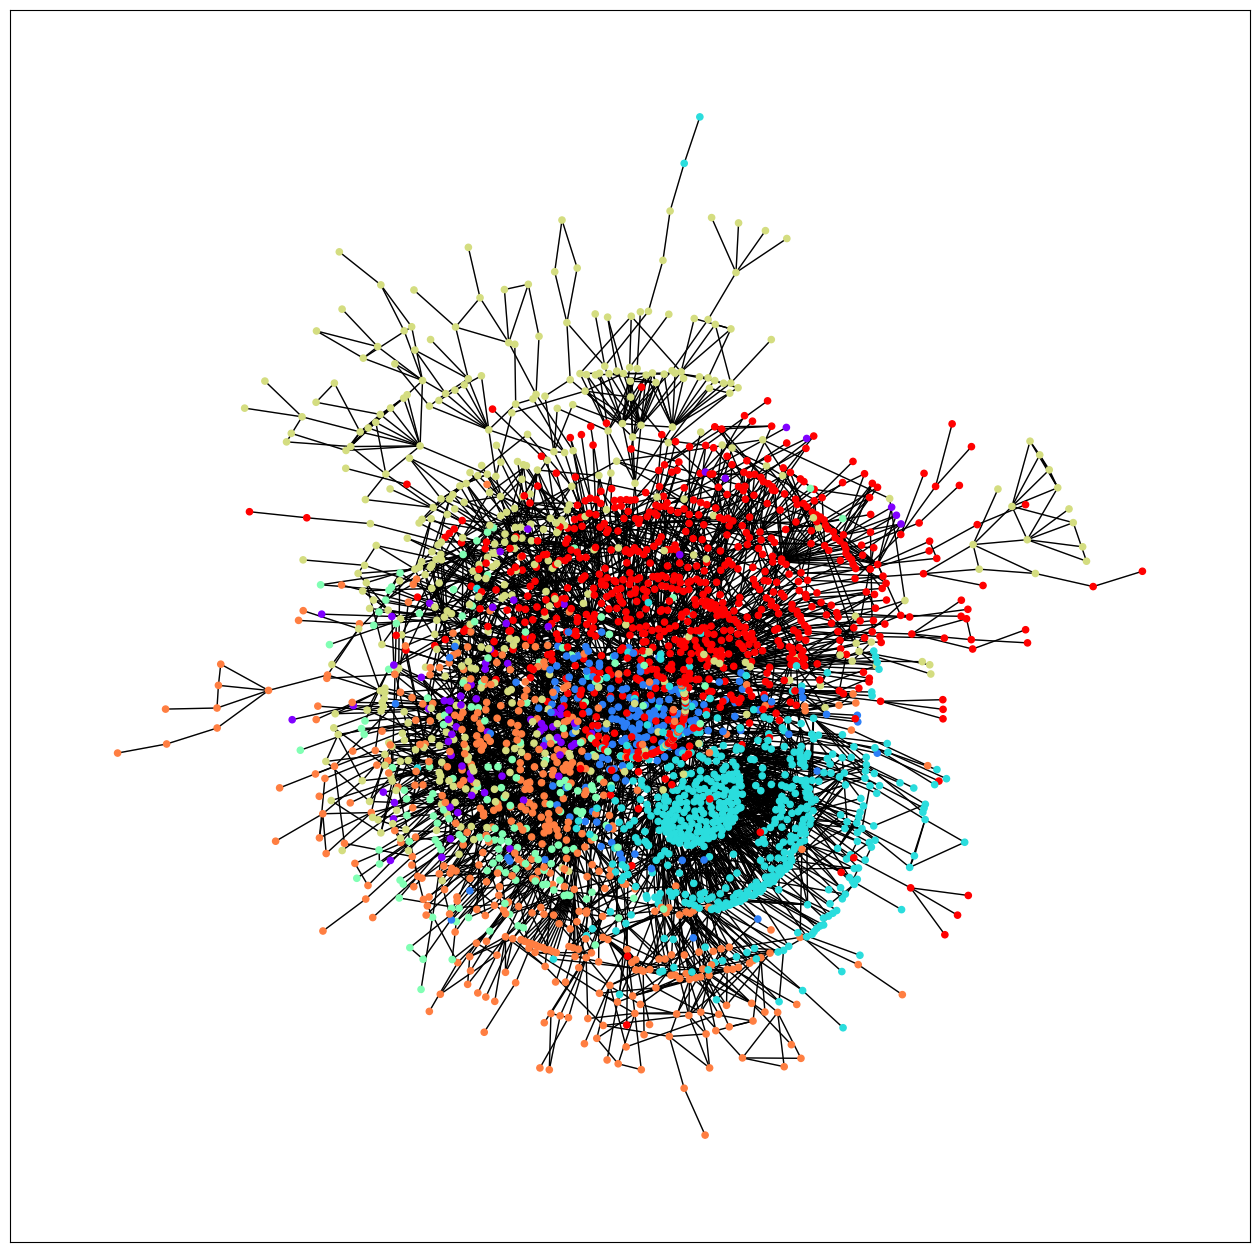

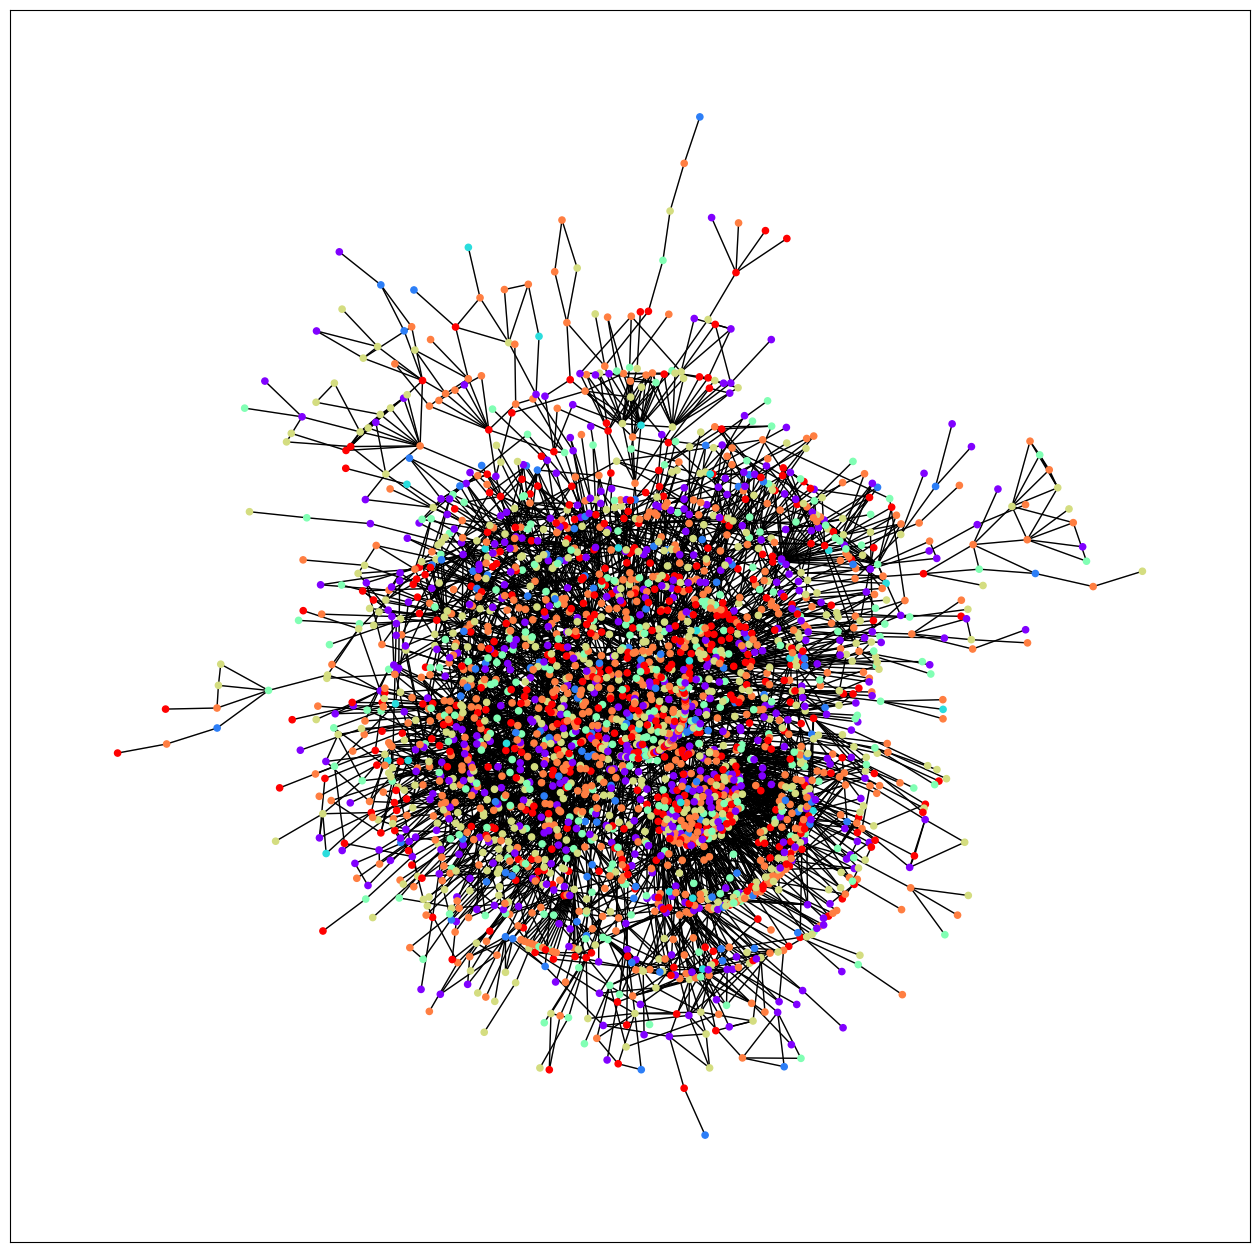

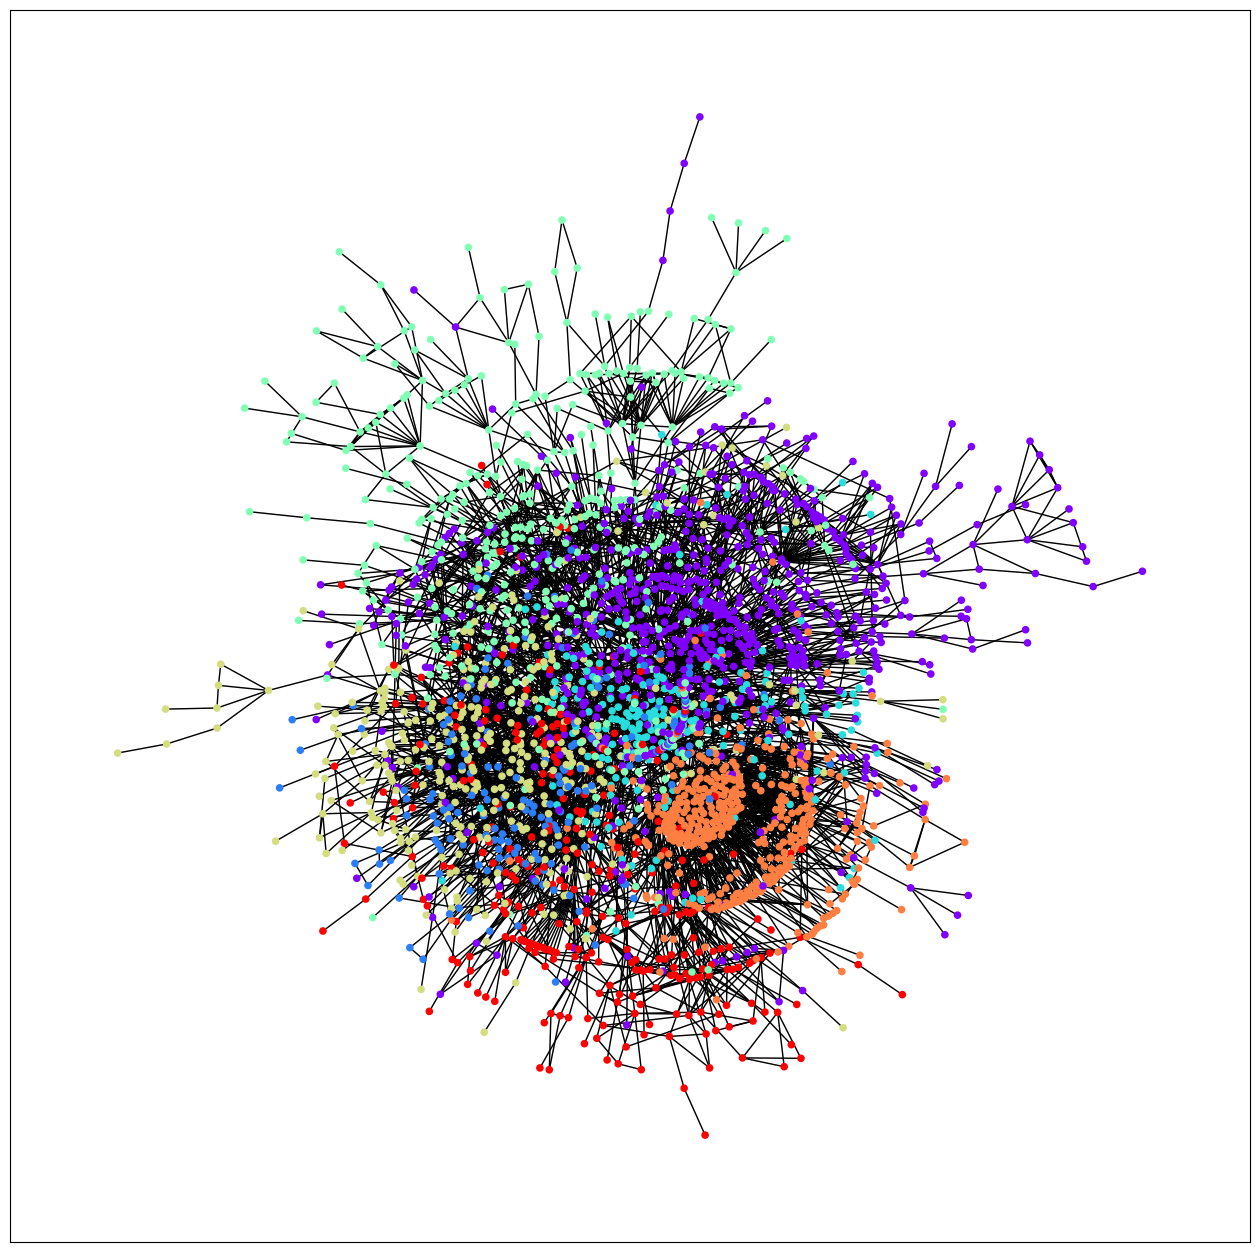

In [77]:
# Visualize the community structure

def visualize_community(edges_path, memberships_list):
    G = nx.Graph()
    edges = np.loadtxt(edges_path, dtype=int)
    G.add_edges_from(edges)
    pos = nx.kamada_kawai_layout(G)
    
    for memberships in memberships_list:
        # Create a consistent label-to-color mapping 
        unique_labels = sorted(np.unique(memberships))  # Get unique labels
        cmap = plt.cm.rainbow  # Choose a colormap
        label_to_color = {label: cmap(i / (len(unique_labels) - 1)) for i, label in enumerate(unique_labels)}
        colors = [label_to_color[memberships[node]] for node in G.nodes]

        plt.figure(figsize=(16, 16))
        nx.draw_networkx_edges(G, pos, alpha=0.1)
        nx.draw_networkx(G, pos, node_color=colors, with_labels=False, node_size=20)
        plt.show()

edges_path = 'dataset/cora/edges.txt'
memberships_list = [y_pred_CDNMF, y_pred_DANMF, y_true]
visualize_community(edges_path, memberships_list)